In [1]:
from transformers import logging

logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *
from torch.utils.data import DataLoader, TensorDataset
from run_model import RunModel
import importlib
from models import MultiClassifier

In [2]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"
all_df = pd.read_csv("./data/data_tenderned.csv")
input_df = sample_data(all_df, label_column)
value_counts = input_df[label_column].value_counts()

Bouwwerkzaamheden                                                                                    1500
Zakelijke dienstverlening: juridisch, marketing, consulting, drukkerij en beveiliging                1500
Diensten inzake afvalwater, afval, reiniging en milieu                                               1500
Software en informatiesystemen                                                                       1500
IT-diensten: adviezen, softwareontwikkeling, internet en ondersteuning                               1500
Dienstverlening op het gebied van architectuur, bouwkunde, civiele techniek en inspectie             1500
Voeding, dranken, tabak en aanverwante producten                                                      200
Makelaarsdiensten                                                                                     200
Landbouw- en veeteelt-, kwekerij-, visserij-, bosbouw- en aanverwante producten                       200
Ondersteunende en aanvullende vervoersdiensten

In [3]:
running_device = torch.device("mps")

In [4]:
prd = ProcessData(input_df, label_column, text_column, test_per_label_num=60)
test_df, suf_df, insuf_df, label_encoder, onehot = prd.process()
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 7, running_device)

Before removing duplicate sentence: 10400
After removing duplicate sentence: 10292
Before drop we have : 10292
After drop cpv with low observations we have : 10292
The num of class is  13
The number of total data is:  10292
Total number of test data is:  780
Total number of train data is:  9512


In [5]:
val_df = test_df.sample(frac=1).groupby(label_column, sort=False).head(20)
test_df = test_df.drop(val_df.index)
train_df = pd.concat([suf_df, insuf_df]).sample(frac=1)

In [6]:
# test_dataset = cd.create(test_df)
# val_dataset = cd.create(val_df)
# suf_dataset = cd.create(suf_df)

test_dataset=torch.load("./data/test.ds")
val_dataset=torch.load("./data/val.ds")
suf_dataset=torch.load("./data/suf.ds")

In [7]:
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
val_dl = DataLoader(val_dataset, shuffle=True, batch_size=20)

In [8]:
insuf_ds_dict = cd.create_label_dataset(insuf_df)
insuf_ds_list = list(insuf_ds_dict.values())
insuf_dataset = torch.utils.data.ConcatDataset(insuf_ds_list)

Getting bert hidden states from layer: 7: 100%|██████████| 138/138 [00:03<00:00, 37.77it/s]


In [69]:
from importlib import reload
import run_model
import utils
import models
reload(utils)
reload(run_model)
reload(models)
from run_model import RunModel
from utils import get_train_val_dataloader
from models import MultiClassifier

In [9]:
model_runner = RunModel(running_device)

In [10]:
noise_train, noise_val = get_train_val_dataloader(suf_dataset, train_weight=0.9)
gan_aug_datasets = []
for insuf_ds in insuf_ds_list:
    source_train, source_val = get_train_val_dataloader(insuf_ds, train_weight=0.8)
    gan_aug_dataset = model_runner.gan_augmentation(source_train, noise_train, source_val, noise_val, glr=1e-9,
                                                    dlr=1e-7, epoch=5, aug_num=50)
    gan_aug_datasets.append(gan_aug_dataset)

train size: 7679
val size:  854
train size: 110
val size:  28
0 discriminator loss:  1.2939202547073365 generator loss : 0.2741106392815709 real acc1:  1.0 fake acc2: 0.7416666646798452
1 discriminator loss:  1.2278582096099853 generator loss : 0.5793216675519943 real acc1:  1.0 fake acc2: 0.8166666626930237
2 discriminator loss:  1.1815308213233948 generator loss : 0.6350201487541198 real acc1:  1.0 fake acc2: 0.825000007947286
3 discriminator loss:  1.1323338270187377 generator loss : 0.6423075944185257 real acc1:  1.0 fake acc2: 0.8916666706403097
4 discriminator loss:  1.0918286263942718 generator loss : 0.6346282809972763 real acc1:  1.0 fake acc2: 0.8583333293596903
train size: 110
val size:  28
0 discriminator loss:  1.2750006020069122 generator loss : 0.27760988790541885 real acc1:  1.0 fake acc2: 0.6083333392937978
1 discriminator loss:  1.1944250285625457 generator loss : 0.5957160741090775 real acc1:  1.0 fake acc2: 0.6083333392937978
2 discriminator loss:  1.122398155927658

In [11]:
original_train_dataset = torch.utils.data.ConcatDataset([insuf_dataset, suf_dataset])

In [12]:
gan_aug_train_dataset = torch.utils.data.ConcatDataset(gan_aug_datasets + [original_train_dataset])
gan_train_dl = DataLoader(gan_aug_train_dataset, shuffle=True, batch_size=20)

0 train loss:  1.7394150189568287 val acc:  0.276923078757066
1 train loss:  0.8972722031987896 val acc:  0.48846155175795924
2 train loss:  0.6331402462327596 val acc:  0.6423077056041131
3 train loss:  0.5345632654612491 val acc:  0.6692307774837201
4 train loss:  0.45520943792009183 val acc:  0.7153846346415006
5 train loss:  0.3913503592973688 val acc:  0.71923078252719
Total MCC: 0.652
Total ACC: 0.675


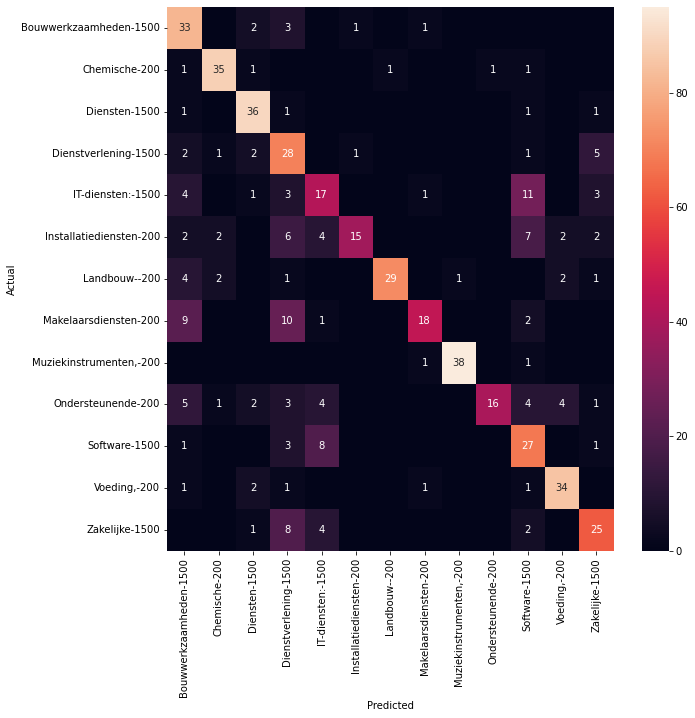

In [15]:
model_runner = RunModel(running_device)
classifier = MultiClassifier(prd.num_class).to(running_device)
classifier = model_runner.train_classifier(gan_train_dl, val_dl, classifier, lr=1e-5, n_epochs=6)
predictions, labels = model_runner.predict(test_dl, classifier)
mcc, acc = evaluate(labels, predictions, prd.label_encoder, prd.num_class, value_counts)

In [16]:
aug_num = 1000
copy_aug_insuf_dataset = []
for insuf_ds in insuf_ds_list:
    aug_insuf_ds = [insuf_ds for i in range(5)]
    copy_aug_insuf_dataset += aug_insuf_ds

In [17]:
copy_aug_train_dataset = torch.utils.data.ConcatDataset(copy_aug_insuf_dataset + [suf_dataset])

In [18]:
original_train_dl = DataLoader(original_train_dataset, shuffle=True, batch_size=20)
copy_aug_train_dl = DataLoader(copy_aug_train_dataset, shuffle=True, batch_size=20)

In [ ]:
classifier = MultiClassifier(prd.num_class).to(running_device)
classifier = model_runner.train_classifier(original_train_dl, val_dl, classifier, lr=1e-5, n_epochs=6)
predictions, labels = model_runner.predict(test_dl, classifier)
mcc, acc = evaluate(labels, predictions, prd.label_encoder, prd.num_class, value_counts)

0 train loss:  2.339990874190829 val acc:  0.3769230842590332
1 train loss:  1.6862620030766102 val acc:  0.5153846259300525
2 train loss:  1.276329610318835 val acc:  0.6230769432508029
3 train loss:  1.0054141349312085 val acc:  0.6346153914928436
4 train loss:  0.845288708850519 val acc:  0.657692320071734
5 train loss:  0.7365129069939478 val acc:  0.6500000243003552
Total MCC: 0.584
Total ACC: 0.610


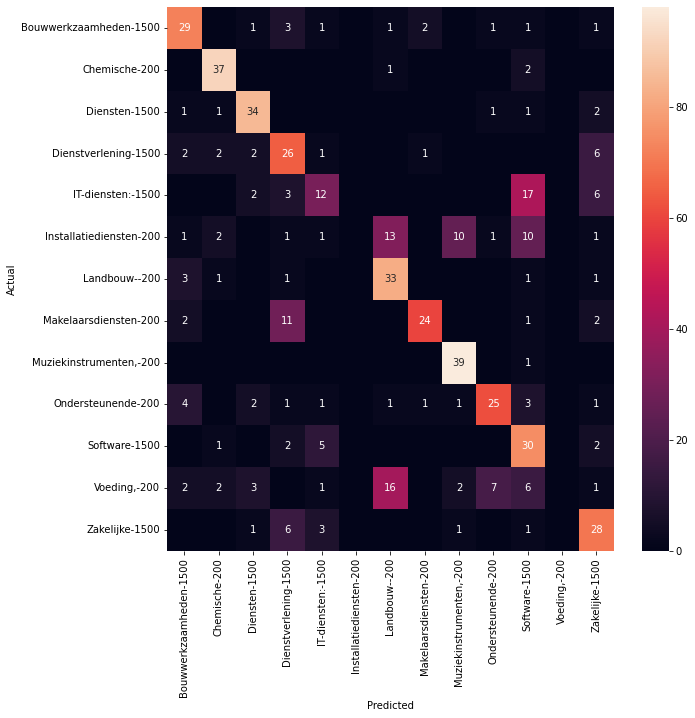

In [19]:
classifier = MultiClassifier(prd.num_class).to(running_device)
classifier = model_runner.train_classifier(copy_aug_train_dl, val_dl, classifier, lr=1e-5, n_epochs=6)
predictions, labels = model_runner.predict(test_dl, classifier)
mcc, acc = evaluate(labels, predictions, prd.label_encoder, prd.num_class, value_counts)